In [3]:
# modified_11_best_model=final_model
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scikeras.wrappers import KerasRegressor
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, InputLayer, BatchNormalization
from keras.regularizers import L1L2
from keras.callbacks import EarlyStopping, ModelCheckpoint


def create_LSTM_regression(input_shape, activation_function, optimizer, num_hidden_layers=2,
                            num_neurons_per_layer=64, dropout_rate=0.2, loss='mean squared error',
                           kernel_regularizer=None, early_stop_patience=None, verbose=None, target_col=None):
  # Initialize RNN
  model = Sequential()

  # Input layer
  model.add(InputLayer(input_shape=input_shape))
  model.add(Dropout(dropout_rate))

  for _ in range(num_hidden_layers):
      model.add(LSTM(num_neurons_per_layer, activation=activation_function,
                    kernel_regularizer=kernel_regularizer, return_sequences=True))
      model.add(Dropout(dropout_rate))

  model.add(LSTM(num_neurons_per_layer, kernel_regularizer=kernel_regularizer,
                return_sequences=False))
  model.add(Dropout(dropout_rate))

  if target_col is not None:
    # Output layer
    model.add(Dense(1))

  else:
    # Output layer
    model.add(Dense(input_shape[-1]))

  model.compile(loss='mean_squared_error', optimizer=optimizer)
  return model


def create_sequence(data, window_size):
    sequences = []
    targets = []
    for i in range(len(data) - window_size):
        sequences.append(data[i:i+window_size])
        targets.append(data[i+window_size])
    return np.array(sequences), np.array(targets)


def prepare_data(data, window_size, target_col=None, test_size=0.2, scaler=MinMaxScaler):
  if target_col is not None:
    # Create a target variable
    data['Target'] = data[target_col].shift(-1)

    # Drop the last row with NaN target
    data.dropna(inplace=True)

    # Drop target_col from data
    data = data.drop(target_col,axis=1)

  # Split the data into train and test sets based on time
  train_size = int(len(data) * (1 - test_size))
  train_data = data.iloc[:train_size]
  test_data = data.iloc[train_size:]

  # Scaling
  scaler = scaler()
  train_data_scaled = scaler.fit_transform(train_data)
  test_data_scaled = scaler.fit_transform(test_data)

  # Create sequence of train and test sets
  X_train, y_train = create_sequence(train_data_scaled, window_size)
  X_test, y_test = create_sequence(test_data_scaled, window_size)

  print(f"X_train shape: {X_train.shape}")
  print(f"y_train shape: {y_train.shape}")
  print(f"X_test shape: {X_test.shape}")
  print(f"y_test shape: {y_test.shape}")

  return X_train, y_train, X_test, y_test

def LSTM_regression_random_search(data, window_size, target_col=None, n_iter=1, cv=3,
                                  verbose=1,dropout_rates=[0.1, 0.2, 0.4],
                                  activation_functions=["relu", "tanh"],
                                  optimizers=["adam", "rmsprop", "adagrad"], 
                                  batch_sizes=[16, 32, 64], epochs=[50, 100, 200],
                                  early_stop_patience=[3, 5, 10],
                                  num_hidden_layers_range=range(1, 4),
                                  neurons_per_layer_range=[16, 32, 64],
                                  learning_rate_range=[0.001, 0.01, 0.1],
                                  model_save=True, save_directory=None,
                                  plot_loss=True, test_size=0.2, random_state=42):

  # Prepare data
  X_train, y_train, X_test, y_test = prepare_data(data=data, window_size=window_size, target_col=target_col)

  input_shape = (window_size, X_train.shape[2])

  # Model
  Keras_Regressor = KerasRegressor(model=create_LSTM_regression, input_shape=input_shape, verbose=verbose)

  # Define the random search parameters
  param_dist = {
      "model__activation_function": activation_functions,
      "model__dropout_rate": dropout_rates,
      "model__optimizer": optimizers,
      "model__num_hidden_layers": num_hidden_layers_range,
      "model__num_neurons_per_layer": neurons_per_layer_range,
      "model__kernel_regularizer": [L1L2(l1=0, l2=regularization_strength) for regularization_strength in learning_rate_range],
      "batch_size": batch_sizes,
      "epochs": epochs,
      "model__early_stop_patience": early_stop_patience
  }

  # Set the logging level to error
  tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

  all_results = []
  
  for i in range(n_iter*10):
    print(f"Iteration {i}")
  
    # Create the RandomizedSearchCV object
    random_search = RandomizedSearchCV(Keras_Regressor, param_distributions=param_dist, n_iter=n_iter,
                                      cv=cv, error_score=np.nan, verbose=verbose)  
    # Create EarlyStopping and ModelCheckpoint callbacks
    es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=verbose, patience=early_stop_patience)
    
    # Fit to the training data
    random_search.fit(X_train, y_train, validation_data=(X_test, y_test),callbacks=[es])

    # Get the best model from the RandomizedSearchCV
    best_model = random_search.best_estimator_

    # Get the best parameters from the RandomizedSearchCV
    best_params = random_search.best_params_

    # create and fit final model with best parameters
    final_model = create_LSTM_regression(input_shape=(window_size, X_train.shape[2]), dropout_rate=best_params['model__dropout_rate'],
                                          activation_function=best_params['model__activation_function'],
                                          optimizer=best_params['model__optimizer'],
                                          num_hidden_layers=best_params['model__num_hidden_layers'],
                                          num_neurons_per_layer=best_params['model__num_neurons_per_layer'],
                                          kernel_regularizer=best_params['model__kernel_regularizer'],
                                          early_stop_patience=best_params['model__early_stop_patience'])
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=verbose, patience=best_params['model__early_stop_patience'])
    mc = ModelCheckpoint(f'final_model{i}.h5', monitor='val_loss', mode='min', verbose=verbose, save_best_only=True)
    history = final_model.fit(X_train, y_train, validation_data=(X_test, y_test),
                              epochs=best_params['epochs'], batch_size=best_params['batch_size'], callbacks=[es, mc])

    # Plotting the training and validation loss
    if plot_loss:
        plt.figure(figsize=(10, 6))
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.title(f'Loss Plot of best model_{i}')
        plt.show()

    # Make predictions using the LSTM model
    y_pred_train = final_model.predict(X_train)
    y_pred_test = final_model.predict(X_test)

    if target_col is not None:
      # Reshape y_test, y_pred, X_test, and X_train to be 2D arrays
      y_train_2d = y_train[:, -1]
      y_test_2d = y_test[:, -1]
      y_pred_train_2d = y_pred_train[:, -1]
      y_pred_test_2d = y_pred_test[:, -1]
      X_train_2d = X_train.reshape(-1, X_train.shape[2])
      X_test_2d = X_test.reshape(-1, X_test.shape[2])
    else:
      # Reshape y_test, y_pred, X_test, and X_train to be 2D arrays
      y_train_2d = y_train.reshape(-1, 1)
      y_test_2d = y_test.reshape(-1, 1)
      y_pred_train_2d = y_pred_train.reshape(-1, 1)
      y_pred_test_2d = y_pred_test.reshape(-1, 1)
      X_train_2d = X_train.reshape(-1, X_train.shape[2])
      X_test_2d = X_test.reshape(-1, X_test.shape[2])

    # Calculate metrics
    train_rmse = np.sqrt(mean_squared_error(y_train_2d, y_pred_train_2d))
    test_rmse = np.sqrt(mean_squared_error(y_test_2d, y_pred_test_2d))
    train_r2 = r2_score(y_train_2d, y_pred_train_2d)
    test_r2 = r2_score(y_test_2d, y_pred_test_2d)

    # Concatenate X_train_scaled and X_test_scaled back into X_scaled
    X_cv = np.concatenate((X_train, X_test), axis=0)
    # Concatenate y_train and y_test back into a y
    y_cv = np.concatenate((y_train, y_test), axis=0)

    # Wrap the Keras model in a scikit-learn estimator
    estimator = KerasRegressor(model=final_model, epochs=best_params['epochs'], batch_size=best_params['batch_size'], verbose=verbose)

    # Calculate CV RMSE and its standard deviation using the cross_val_score for the best model
    cv_scores = cross_val_score(estimator, X_cv, y_cv, scoring='neg_mean_squared_error', cv=5)
    rmse_scores = np.sqrt(-cv_scores)
    cv_rmse = np.mean(rmse_scores)
    cv_rmse_std = np.std(rmse_scores)

    # Create a figure and axis object
    fig, ax = plt.subplots(figsize=(12, 6))

    # Plot the predicted values
    sns.lineplot(data=y_pred_test_2d.flatten(), ax=ax, color='red', label='Predicted')

    # Plot the actual values
    sns.lineplot(data=y_test_2d, ax=ax, color='blue', label='Actual')

    # Set the axis labels and title
    ax.set_xlabel('Time')
    ax.set_ylabel('Value')
    ax.set_title(f'Comparison of predicted and actual values of best model_{i}')

    # Display the plot
    plt.show()

    # Create a dataframe with results
    model_results = {
        "Model": [f"LSTM Regression with Random Search (best model_{i})"],
        "Train R²": [round(train_r2, 3)],
        "Test R²": [round(test_r2, 3)],
        "Train RMSE": [round(train_rmse, 3)],
        "Test RMSE": [round(test_rmse, 3)],
        "CV RMSE": [round(cv_rmse, 3)],
        "CV RMSE Std": [round(cv_rmse_std, 3)],
        "Best Hyperparameters": [best_params]
    }

    # Append the results to the all_results list
    all_results.append(pd.DataFrame(model_results))

    # Concatenate all the results into a single DataFrame
    results_df = pd.concat(all_results, axis=0)
    
  return results_df




2023-08-02 10:29:27.891021: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-02 10:29:27.994106: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-02 10:29:27.995663: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-02 10:29:28.700593: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
# modified_11_supervised + unsupervised_modify data setup_scaling whole data_+BatchNormalization
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scikeras.wrappers import KerasRegressor
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, InputLayer, BatchNormalization
from keras.regularizers import L1L2
from keras.callbacks import EarlyStopping, ModelCheckpoint


def create_LSTM_regression(input_shape, activation_function, optimizer, num_hidden_layers=2,
                            num_neurons_per_layer=64, dropout_rate=0.2, loss='mean squared error',
                           kernel_regularizer=None, early_stop_patience=None, verbose=None, target_col=None):
  # Initialize RNN
  model = Sequential()

  # Input layer
  model.add(InputLayer(input_shape=input_shape))
  model.add(Dropout(dropout_rate))

  for _ in range(num_hidden_layers):
      model.add(LSTM(num_neurons_per_layer, activation=activation_function,
                    kernel_regularizer=kernel_regularizer, return_sequences=True))
      model.add(Dropout(dropout_rate))

  model.add(LSTM(num_neurons_per_layer, kernel_regularizer=kernel_regularizer,
                return_sequences=False))
  model.add(Dropout(dropout_rate))

  if target_col is not None:
    # Output layer
    model.add(Dense(1))

  else:
    # Output layer
    model.add(Dense(input_shape[-1]))

  model.compile(loss='mean_squared_error', optimizer=optimizer)
  return model


def create_sequence(data, window_size):
    sequences = []
    targets = []
    for i in range(len(data) - window_size):
        sequences.append(data[i:i+window_size])
        targets.append(data[i+window_size])
    return np.array(sequences), np.array(targets)


def prepare_data(data, window_size, target_col=None, test_size=0.2, scaler=MinMaxScaler):
  if target_col is not None:
    # Create a target variable
    data['Target'] = data[target_col].shift(-1)

    # Drop the last row with NaN target
    data.dropna(inplace=True)

    # Drop target_col from data
    data = data.drop(target_col,axis=1)

  # Split the data into train and test sets based on time
  train_size = int(len(data) * (1 - test_size))
  train_data = data.iloc[:train_size]
  test_data = data.iloc[train_size:]

  # Scaling
  scaler = scaler()
  train_data_scaled = scaler.fit_transform(train_data)
  test_data_scaled = scaler.fit_transform(test_data)

  # Create sequence of train and test sets
  X_train, y_train = create_sequence(train_data_scaled, window_size)
  X_test, y_test = create_sequence(test_data_scaled, window_size)

  print(f"X_train shape: {X_train.shape}")
  print(f"y_train shape: {y_train.shape}")
  print(f"X_test shape: {X_test.shape}")
  print(f"y_test shape: {y_test.shape}")

  return X_train, y_train, X_test, y_test

def LSTM_regression_random_search(data, window_size, target_col=None, n_iter=1, n_times=1, cv=3,
                                  verbose=1,dropout_rates=[0.1, 0.2, 0.3, 0.4],
                                  activation_functions=["relu", "tanh"],
                                  optimizers=["adam", "rmsprop", "adagrad"], 
                                  batch_sizes=[16, 32, 64], epochs=[50, 100, 200],
                                  early_stop_patience=[5, 10, 15],
                                  num_hidden_layers_range=range(1, 4),
                                  neurons_per_layer_range=[16, 32, 64],
                                  learning_rate_range=[0.0001, 0.001, 0.01, 0.1],
                                  model_save=True, save_directory=None,
                                  plot_loss=True, test_size=0.2, random_state=42):

  # Prepare data
  X_train, y_train, X_test, y_test = prepare_data(data=data, window_size=window_size, target_col=target_col)

  input_shape = (window_size, X_train.shape[2])

  # Model
  Keras_Regressor = KerasRegressor(model=create_LSTM_regression, input_shape=input_shape, verbose=verbose)

  # Define the random search parameters
  param_dist = {
      "model__activation_function": activation_functions,
      "model__dropout_rate": dropout_rates,
      "model__optimizer": optimizers,
      "model__num_hidden_layers": num_hidden_layers_range,
      "model__num_neurons_per_layer": neurons_per_layer_range,
      "model__kernel_regularizer": [L1L2(l1=0, l2=regularization_strength) for regularization_strength in learning_rate_range],
      "batch_size": batch_sizes,
      "epochs": epochs,
      "model__early_stop_patience": early_stop_patience
  }

  # Set the logging level to error
  tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

  all_results = []
  
  for i in range(n_times):
    print(f"Iteration {i}")
  
    # Create the RandomizedSearchCV object
    random_search = RandomizedSearchCV(Keras_Regressor, param_distributions=param_dist, n_iter=n_iter,
                                      cv=cv, error_score=np.nan, verbose=verbose)  
    # Create EarlyStopping and ModelCheckpoint callbacks
    es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=verbose, patience=early_stop_patience)
    
    # Fit to the training data
    random_search.fit(X_train, y_train, validation_data=(X_test, y_test),callbacks=[es])

    # Get the best model from the RandomizedSearchCV
    best_model = random_search.best_estimator_

    # Get the best parameters from the RandomizedSearchCV
    best_params = random_search.best_params_

    # create and fit final model with best parameters
    final_model = create_LSTM_regression(input_shape=(window_size, X_train.shape[2]), dropout_rate=best_params['model__dropout_rate'],
                                          activation_function=best_params['model__activation_function'],
                                          optimizer=best_params['model__optimizer'],
                                          num_hidden_layers=best_params['model__num_hidden_layers'],
                                          num_neurons_per_layer=best_params['model__num_neurons_per_layer'],
                                          kernel_regularizer=best_params['model__kernel_regularizer'],
                                          early_stop_patience=best_params['model__early_stop_patience'])
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=verbose, patience=best_params['model__early_stop_patience'])
    mc = ModelCheckpoint(f'final_model{i}.h5', monitor='val_loss', mode='min', verbose=verbose, save_best_only=True)
    history = final_model.fit(X_train, y_train, validation_data=(X_test, y_test),
                              epochs=best_params['epochs'], batch_size=best_params['batch_size'], callbacks=[es, mc])

    # Plotting the training and validation loss
    if plot_loss:
        plt.figure(figsize=(10, 6))
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.title(f'Loss Plot of best model_{i}')
        plt.show()

    # Make predictions using the LSTM model
    y_pred_train = final_model.predict(X_train)
    y_pred_test = final_model.predict(X_test)

    if target_col is not None:
      # Reshape y_test, y_pred, X_test, and X_train to be 2D arrays
      y_train_2d = y_train[:, -1]
      y_test_2d = y_test[:, -1]
      y_pred_train_2d = y_pred_train[:, -1]
      y_pred_test_2d = y_pred_test[:, -1]
      X_train_2d = X_train.reshape(-1, X_train.shape[2])
      X_test_2d = X_test.reshape(-1, X_test.shape[2])
    else:
      # Reshape y_test, y_pred, X_test, and X_train to be 2D arrays
      y_train_2d = y_train.reshape(-1, 1)
      y_test_2d = y_test.reshape(-1, 1)
      y_pred_train_2d = y_pred_train.reshape(-1, 1)
      y_pred_test_2d = y_pred_test.reshape(-1, 1)
      X_train_2d = X_train.reshape(-1, X_train.shape[2])
      X_test_2d = X_test.reshape(-1, X_test.shape[2])

    # Calculate metrics
    train_mse = mean_squared_error(y_train_2d, y_pred_train_2d)
    test_mse = mean_squared_error(y_test_2d, y_pred_test_2d)
    train_r2 = r2_score(y_train_2d, y_pred_train_2d)
    test_r2 = r2_score(y_test_2d, y_pred_test_2d)

    # Create a figure and axis object
    fig, ax = plt.subplots(figsize=(12, 6))

    # Plot the predicted values
    sns.lineplot(data=y_pred_test_2d.flatten(), ax=ax, color='red', label='Predicted')

    # Plot the actual values
    sns.lineplot(data=y_test_2d, ax=ax, color='blue', label='Actual')

    # Set the axis labels and title
    ax.set_xlabel('Time')
    ax.set_ylabel('Value')
    ax.set_title(f'Comparison of predicted and actual values of best model_{i}')

    # Display the plot
    plt.show()

    # Create a dataframe with results
    model_results = {
        "Model": [f"LSTM Regression with Random Search (best model_{i})"],
        "Train R²": [round(train_r2, 3)],
        "Test R²": [round(test_r2, 3)],
        "Train MSE": [round(train_mse, 3)],
        "Test MSE": [round(test_mse, 3)],
        "Best Hyperparameters": [best_params]
    }

    # Append the results to the all_results list
    all_results.append(pd.DataFrame(model_results))

    # Concatenate all the results into a single DataFrame
    results_df = pd.concat(all_results, axis=0)
    
  return results_df




In [5]:
data = pd.read_csv("/home/young78703/Data_Science_Project/data/bitcoin_data/BTC-Hourly.csv")
data = data.drop(columns=['date', 'unix', 'symbol', 'Volume BTC'])
data.head()

,open,high,low,close,Volume USD
0,43221.71,43626.49,43185.48,43312.27,2.254677e+06
1,43085.30,43364.81,42892.37,43178.98,4.612210e+06
2,41657.23,44256.08,41650.29,42907.32,2.263535e+07
3,41917.09,41917.09,41542.60,41659.53,2.905822e+06
4,41361.99,41971.00,41284.11,41914.97,1.035935e+07


In [28]:
import yfinance as yf
# Load the data from Yahoo Finance
symbol = 'AAPL'
start_date = '2020-01-01'
end_date = '2023-07-12'
data = yf.download(symbol, start=start_date, end=end_date)
data = data.drop('Adj Close', axis=1)

[*********************100%***********************]  1 of 1 completed


X_train shape: (26596, 10, 5)
y_train shape: (26596, 5)
X_test shape: (6642, 10, 5)
y_test shape: (6642, 5)
Iteration 0
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Epoch 1/200
555/555 [==============================] - 7s 8ms/step - loss: 0.6985 - val_loss: 0.1601
Epoch 2/200
555/555 [==============================] - 4s 7ms/step - loss: 0.0150 - val_loss: 0.1591
Epoch 3/200
555/555 [==============================] - 4s 7ms/step - loss: 0.0149 - val_loss: 0.1496
Epoch 4/200
555/555 [==============================] - 4s 7ms/step - loss: 0.0149 - val_loss: 0.1430
Epoch 5/200
555/555 [==============================] - 4s 7ms/step - loss: 0.0149 - val_loss: 0.1528
Epoch 6/200
555/555 [==============================] - 4s 7ms/step - loss: 0.0149 - val_loss: 0.1531
Epoch 7/200
555/555 [==============================] - 4s 7ms/step - loss: 0.0149 - val_loss: 0.1577
Epoch 8/200
555/555 [==============================] - 4s 7ms/step - loss: 0.0149 - val_loss: 0.1564
Epoch 9/200
5

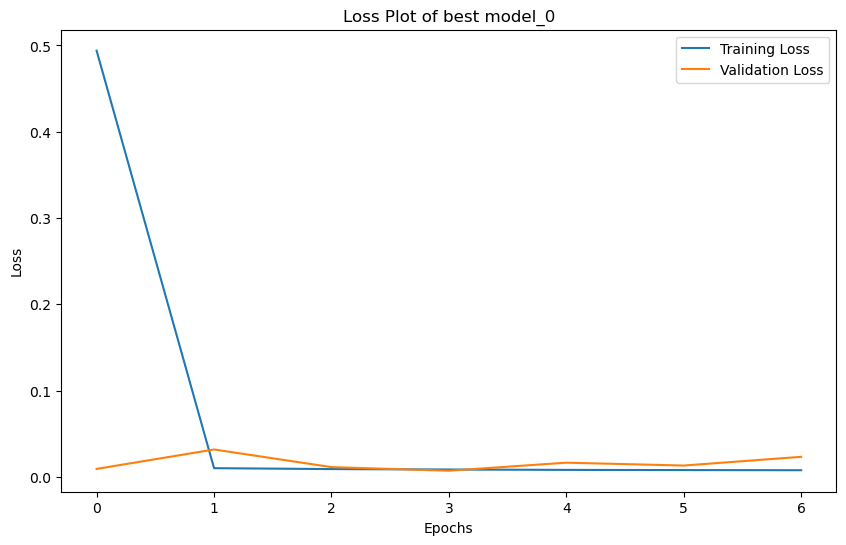

208/208 [==============================] - 0s 2ms/step


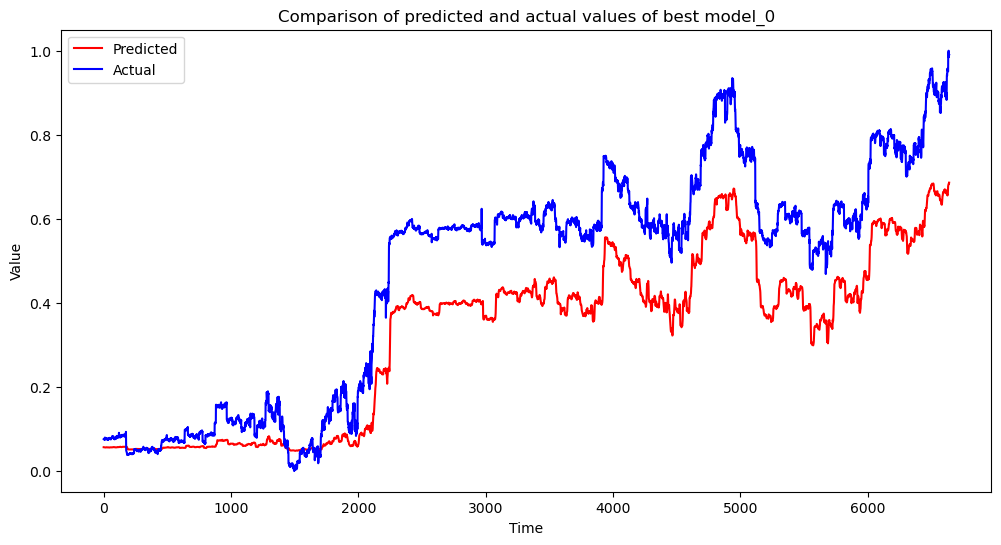

Iteration 1
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Epoch 1/50
1109/1109 [==============================] - 8s 6ms/step - loss: 0.0023 - val_loss: 0.0018
Epoch 2/50
1109/1109 [==============================] - 6s 6ms/step - loss: 7.3807e-04 - val_loss: 0.0061
Epoch 3/50
1109/1109 [==============================] - 6s 6ms/step - loss: 6.4304e-04 - val_loss: 0.0025
Epoch 4/50
1109/1109 [==============================] - 7s 6ms/step - loss: 5.9076e-04 - val_loss: 0.0017
Epoch 5/50
1109/1109 [==============================] - 6s 6ms/step - loss: 6.1456e-04 - val_loss: 0.0018
Epoch 6/50
1109/1109 [==============================] - 6s 6ms/step - loss: 5.6275e-04 - val_loss: 0.0036
Epoch 7/50
1109/1109 [==============================] - 6s 6ms/step - loss: 5.4896e-04 - val_loss: 0.0016
Epoch 8/50
1109/1109 [==============================] - 6s 6ms/step - loss: 5.6935e-04 - val_loss: 0.0086
Epoch 9/50
1109/1109 [==============================] - 6s 6ms/step - loss: 5.6061e-0

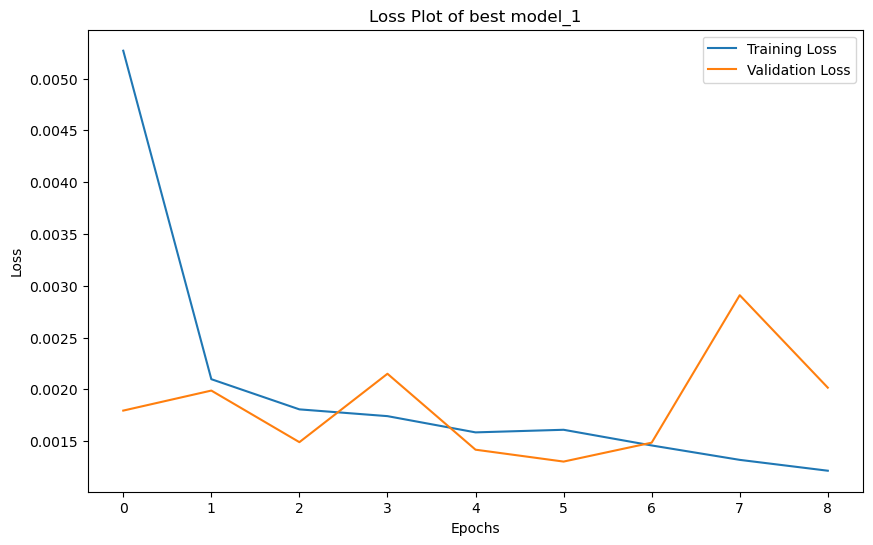

208/208 [==============================] - 0s 2ms/step


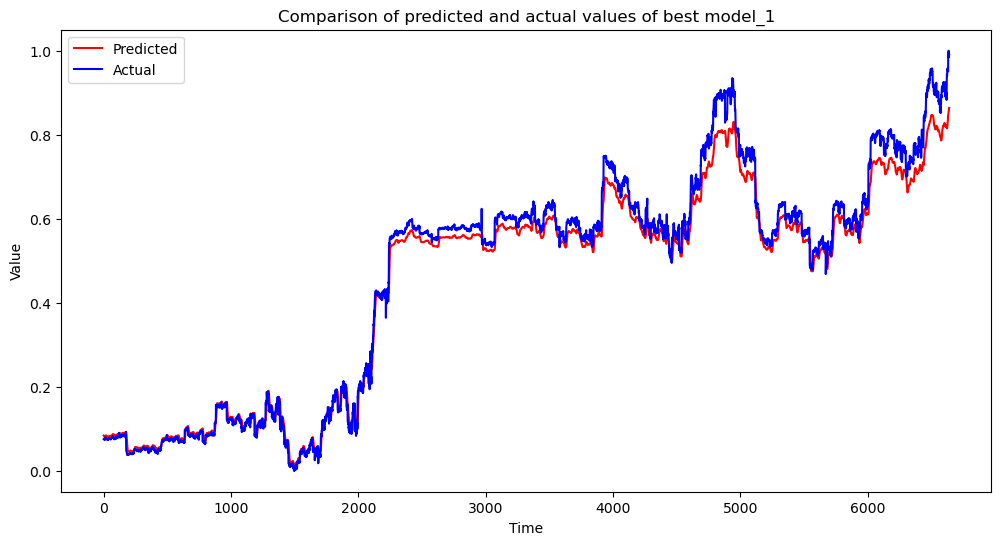

In [6]:
result_df = LSTM_regression_random_search(data, 10, target_col='close', n_iter=1, n_times=2, save_directory=None, model_save=True)
output_file_path = "/home/young78703/Data_Science_Project/LSTM_regression_random_search_output.csv"
result_df.to_csv(output_file_path, index=False)